In [2]:
import torch
import geoopt
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import grad

## 1. Geometry Overview

In [3]:

manifold_p = geoopt.PoincareBall(c=1.0)
manifold_l = geoopt.Lorentz(k=1.0)

print("Poincaré manifold:", manifold_p)
print("Lorentz manifold:", manifold_l)


Poincaré manifold: PoincareBall manifold
Lorentz manifold: Lorentz manifold


## 2. Tangent Space, Exp/Log Maps

In [4]:
# Origin point and tangent vector in Poincaré
x_p = torch.tensor([[0.0, 0.0]], dtype=torch.float64)
v_p = torch.tensor([[0.6, 0.3]], dtype=torch.float64)

exp_p = manifold_p.expmap(x_p, v_p)
log_p = manifold_p.logmap(x_p, exp_p)

print("Exp(Poincaré):", exp_p)
print("Log(Poincaré):", log_p)

Exp(Poincaré): tensor([[0.5237, 0.2619]], dtype=torch.float64)
Log(Poincaré): tensor([[0.6000, 0.3000]], dtype=torch.float64)


In [5]:

# Lorentz point and vector
x_l = torch.tensor([[1.25, 0.3, 0.2]], dtype=torch.float64)
v_l = torch.tensor([[0.0, 0.05, 0.04]], dtype=torch.float64)

exp_l = manifold_l.expmap(x_l, v_l)
log_l = manifold_l.logmap(x_l, exp_l)

print("Exp(Lorentz):", exp_l)
print("Log(Lorentz):", log_l)

Exp(Lorentz): tensor([[1.0899, 0.3576, 0.2451]], dtype=torch.float64)
Log(Lorentz): tensor([[-2637.8791,   -26.7245,    24.3147]], dtype=torch.float64)


## 3. Numerical Instability in Poincaré

In [6]:

# Large tangent vector near boundary
x = torch.tensor([[0.99, 0.0]], dtype=torch.float64, requires_grad=True)
v = torch.tensor([[0.5, 0.0]], dtype=torch.float64)

try:
    y = manifold_p.expmap(x, v)
    print("Expmap near boundary (Poincaré):", y)
except Exception as e:
    print("Numerical instability occurred:", e)

Expmap near boundary (Poincaré): tensor([[1.0000, 0.0000]], dtype=torch.float64, grad_fn=<WhereBackward0>)


## 4. Euclidean vs Riemannian Gradient in Lorentz

In [7]:

x = torch.tensor([[1.25, 0.3, 0.2]], dtype=torch.float64, requires_grad=True)
loss = (x ** 2).sum()
egrad = grad(loss, x, create_graph=True)[0]

rgrad = manifold_l.egrad2rgrad(x, egrad)
print("Euclidean grad:", egrad)
print("Riemannian grad:", rgrad)


Euclidean grad: tensor([[-2.5000,  0.6000,  0.4000]], dtype=torch.float64,
       grad_fn=<CopySlices>)
Riemannian grad: tensor([[1.7313, 1.6155, 1.0770]], dtype=torch.float64,
       grad_fn=<AddcmulBackward0>)


## 5. Optimization Step in Lorentz

In [8]:

x = torch.tensor([[1.25, 0.3, 0.2]], dtype=torch.float64, requires_grad=True)
lr = 0.01

loss = (x ** 2).sum()
egrad = grad(loss, x)[0]
rgrad = manifold_l.egrad2rgrad(x, egrad)

# Take step on manifold using expmap
x_next = manifold_l.expmap(x, -lr * rgrad)
print("Next point on Lorentz manifold:", x_next)


Next point on Lorentz manifold: tensor([[1.0583, 0.2883, 0.1922]], dtype=torch.float64, grad_fn=<CatBackward0>)


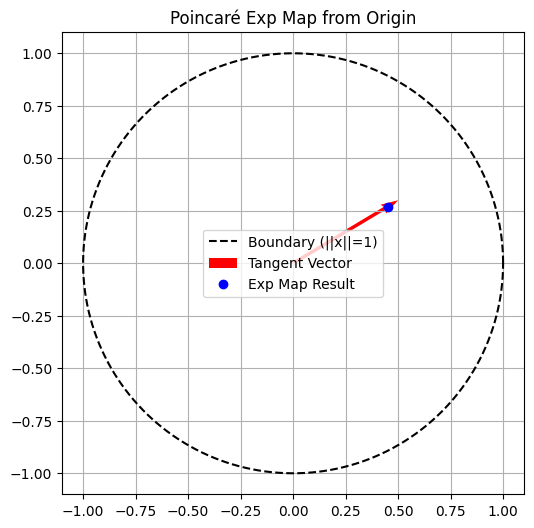

In [10]:

manifold_p = geoopt.PoincareBall()

# Define origin and tangent vector
origin = torch.tensor([[0.0, 0.0]], dtype=torch.float64)
v = torch.tensor([[0.5, 0.3]], dtype=torch.float64)

# Exp map result
exp_point = manifold_p.expmap(origin, v).detach().numpy()

# Circle boundary
theta = np.linspace(0, 2*np.pi, 200)
circle = np.stack([np.cos(theta), np.sin(theta)], axis=1)

# Plot
plt.figure(figsize=(6,6))
plt.plot(circle[:,0], circle[:,1], 'k--', label="Boundary (||x||=1)")
plt.quiver(origin[0,0], origin[0,1], v[0,0], v[0,1], angles='xy', scale_units='xy', scale=1, color='red', label='Tangent Vector')
plt.plot(exp_point[0][0], exp_point[0][1], 'bo', label='Exp Map Result')  # <-- fix here
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.gca().set_aspect('equal')
plt.title("Poincaré Exp Map from Origin")
plt.legend()
plt.grid(True)
plt.show()


In [11]:

x = torch.tensor([[0.99, 0.0]], dtype=torch.float64)
v_large = torch.tensor([[0.5, 0.0]], dtype=torch.float64)

try:
    exp_result = manifold_p.expmap(x, v_large)
    print("Expmap result:", exp_result)
except Exception as e:
    print("Numerical instability:", e)


Expmap result: tensor([[1.0000, 0.0000]], dtype=torch.float64)


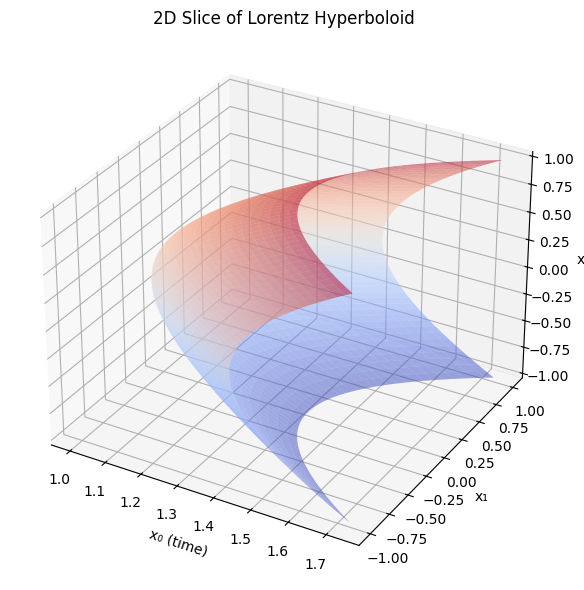

In [12]:

from mpl_toolkits.mplot3d import Axes3D

manifold_l = geoopt.Lorentz()

# Sample curve on the hyperboloid (x0^2 - x1^2 - x2^2 = 1)
x1 = np.linspace(-1, 1, 200)
x2 = np.linspace(-1, 1, 200)
x1_grid, x2_grid = np.meshgrid(x1, x2)
x0_grid = np.sqrt(1 + x1_grid**2 + x2_grid**2)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x0_grid, x1_grid, x2_grid, alpha=0.5, cmap='coolwarm')
ax.set_xlabel("x₀ (time)")
ax.set_ylabel("x₁")
ax.set_zlabel("x₂")
ax.set_title("2D Slice of Lorentz Hyperboloid")
plt.tight_layout()
plt.show()
